<a href="https://colab.research.google.com/github/dhanushnayak/plant_disease_predict/blob/main/Plant_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow==2.5.0
import matplotlib.pyplot as plt
import matplotlib as m
m.rcParams['figure.figsize'] = (16,8)
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm,tqdm_notebook
import time
import tensorflow as tf
from tensorflow.keras import models,layers,Model
from tensorflow import keras

In [ ]:
[1]*10**10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.__version__

'2.5.0'

In [ ]:
glob.glob("drive/*/*")

['drive/MyDrive/Colab Notebooks',
 'drive/MyDrive/plant_dataset.zip',
 'drive/MyDrive/plant_dataset']

In [ ]:
glob.glob("drive/MyDrive/plant_dataset/PlantVillage/*")

['drive/MyDrive/plant_dataset/PlantVillage/Pepper__bell___Bacterial_spot',
 'drive/MyDrive/plant_dataset/PlantVillage/Pepper__bell___healthy',
 'drive/MyDrive/plant_dataset/PlantVillage/Potato___Early_blight',
 'drive/MyDrive/plant_dataset/PlantVillage/Potato___Late_blight',
 'drive/MyDrive/plant_dataset/PlantVillage/Potato___healthy',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato_Bacterial_spot',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato_Early_blight',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato_Late_blight',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato_Leaf_Mold',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato_Septoria_leaf_spot',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato__Target_Spot',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus',
 'drive/MyDrive/plant_dataset/PlantVillage/Tomato__Tomato_mosaic_virus',
 'drive/MyDrive/plant_d

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/plant_dataset/PlantVillage',
    shuffle=True,
    image_size=(224,224),
    batch_size= 16
    )

Found 20638 files belonging to 15 classes.


In [ ]:
class_name = dataset.class_names
class_name

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

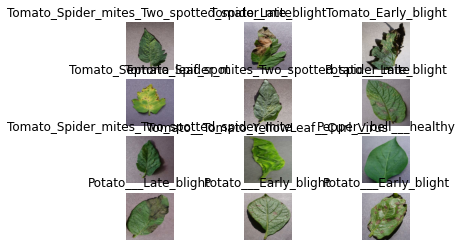

In [ ]:
fig,ax=plt.subplots(ncols=3,nrows=4)
for img_batch,label in dataset.take(1):
    c=0
    for i in range(12):
        k=i%3
        ax[c,k].imshow(img_batch[i].numpy().astype('uint8'))
        ax[c,k].axis('off')
        ax[c,k].set_title(class_name[label.numpy()[i]])
        if k==2:c+=1
        

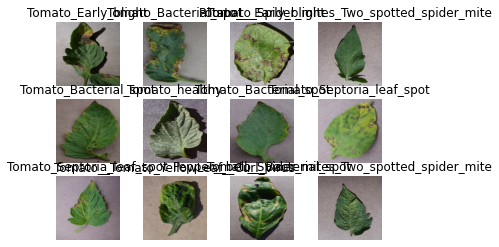

In [ ]:
for img_batch,label in dataset.take(1):

    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_name[label.numpy()[i]])
    
        

In [ ]:
img_size =224
batch_size = 16
channel = 3
epochs = 10

In [ ]:
train_size =0.8
len(dataset)*train_size

1032.0

In [ ]:
train_ds = dataset.take(1032)
len(train_ds)

1032

In [ ]:
test_ds = dataset.skip(1032)
len(test_ds)

258

In [ ]:
val_size = 0.1
len(dataset)*val_size

129.0

In [ ]:
val_ds = test_ds.take(65)
test_ds = test_ds.skip(65)

In [ ]:
len(val_ds),len(test_ds)

(65, 193)

In [ ]:
def get_dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds =  ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset_split(dataset)

In [ ]:
len(train_ds),len(val_ds),len(test_ds)

(1032, 129, 129)

# prefetch

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_aug =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
n_classes = len(class_name)
n_classes

15

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
input_shape_1 = [224,224,channel]
incept = InceptionV3(input_shape = input_shape_1,weights='imagenet',include_top=False)

In [ ]:
for layer in incept.layers:
  layer.trainable=False

In [ ]:
n_classes

15

In [ ]:
x=layers.Flatten()(incept.output)

pred = tf.keras.layers.Dense(len(class_name),activation='softmax')(x)
model_v1 = tf.keras.Model(inputs=incept.input, outputs=pred)

In [ ]:
input_shape_1

[224, 224, 3]

In [ ]:
model_v1.build(input_shape=input_shape_1)
model_v1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:

input_shape = (batch_size,img_size,img_size,channel)
model=models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32,(3,3), activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(512,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (16, 224, 224, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (16, 224, 224, 3)         0         
_________________________________________________________________
conv2d_94 (Conv2D)           (16, 222, 222, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (16, 111, 111, 32)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (16, 109, 109, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (16, 54, 54, 64)          0         
_________________________________________________________________
conv2d_96 (Conv2D)           (16, 52, 52, 512)        

In [ ]:
init_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=init_lr,
    decay_steps=2,
    decay_rate=0.98,
)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [ ]:
model.compile(
    optimizer=adam,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy'
)

In [ ]:

#!pip install livelossplot
#from livelossplot import PlotLosses,PlotLossesIgnite,PlotLossesKeras,PlotLossesKerasTF
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10,mode='max',restore_best_weights=False)
callback = [early_stop]


In [ ]:
history=model.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=val_ds,
          callbacks=callback,
          verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
plt.figure(figsize=(20,20))
for img_batch , label_batch  in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        first_img = img_batch[i].numpy().astype('uint8')
        first_label = label_batch[i]
        #print('first image to predict')
        plt.imshow(first_img)
        a=("Actual _ =  {}".format(class_name[first_label]))
        pred = model.predict(img_batch)
        plt.title(a + "\nPredict = "+class_name[np.argmax(pred[i])])
        plt.axis('off')
        

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    predict = model.predict(img_array)
    pred = class_name[np.argmax(predict)]
    confi = round(max(predict[0]),2) * 100
    return pred,confi

In [ ]:
import cv2
img=cv2.imread('D://dataset/PlantVillage/Pepper__bell___healthy/00100ffa-095e-4881-aebf-61fe5af7226e___JR_HL 7886.JPG')

In [ ]:
predict(model,img)

In [ ]:
model.save("./models/model_v3")

In [ ]:
loaded_model = models.load_model('./models/model_v3/')

In [ ]:
predict(loaded_model,img)